## Importando as Bibliotecas

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go

## Implementação Inicial carregando e as bases de dados

In [2]:
df = pd.read_csv("C:/Users/Cristiano/OneDrive - Belago Technologies/Documentos/projeto_fnt/data/ZAR-21106_20200205_20231107.csv")
df2 = pd.read_csv("C:/Users/Cristiano/OneDrive - Belago Technologies/Documentos/projeto_fnt/data/ZAR-20001336_20231108_20241227.csv")

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_40492\1806991170.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/Cristiano/OneDrive - Belago Technologies/Documentos/projeto_fnt/data/ZAR-21106_20200205_20231107.csv")


In [3]:
df.head(2)

,uid,regiao,operacao,original,descritivo,temperatura,temperaturatermometro,responsavel,substituidopor,amplitude,status,checkedat,dataref,year,month,day
0,thermo_ID_21106_20200205_194353,NORTE,ARARAQUARA,thermo_ID_21106,NaN,28.0,28.0,NaN,NaN,8.0,Normal,2020-02-05 19:43:53,2020-02-05,2020,2,5
1,thermo_ID_21106_20200205_195351,NORTE,ARARAQUARA,thermo_ID_21106,NaN,28.0,28.0,NaN,NaN,8.0,Normal,2020-02-05 19:53:51,2020-02-05,2020,2,5


In [4]:
df2.head(2)

,uid,regiao,operacao,original,descritivo,temperatura,temperaturatermometro,responsavel,substituidopor,amplitude,status,checkedat,dataref,year,month,day
0,thermo_id_20001336_20231108_085106,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,NaN,37.6,37.6,NaN,NaN,0.0,Normal,2023-11-08 08:51:06,2023-11-08,2023,11,8
1,thermo_id_20001336_20231108_095105,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,NaN,42.9,42.9,NaN,NaN,6.7,Normal,2023-11-08 09:51:05,2023-11-08,2023,11,8


In [5]:
# Concatenar os dois dataframes
df_combined = pd.concat([df, df2], ignore_index=True)
df_combined['operacao'] = 'araraquara'
df_combined.drop(columns=['uid', 'descritivo', 'temperatura', 'responsavel', 'substituidopor', 'checkedat'], inplace=True)

In [6]:
df_normal = df_combined

## Análise de Dados

In [7]:
# Classificar erros no DataFrame
df_normal['error_category'] = df_normal.apply(
    lambda row: row['status'] if row['status'] != 'Normal' else ('Erro Consistência' if row['temperaturatermometro'] < 0 or row['temperaturatermometro'] > 65 else 'Normal'),
    axis=1
)

In [8]:
# 1a) Quantidade e porcentagem de medidas com status Normal X Com qualquer erro
status_counts = df_normal['error_category'].value_counts()
total_measures = len(df_normal)
status_percentages = (status_counts / total_measures * 100).round(2)

In [9]:
status_percentages

error_category
Normal               91.18
ErroTOCF              6.11
ManualEquipamento     1.57
ErroTO                1.05
Erro Consistência     0.09
Name: count, dtype: float64

## Gráfico Dash Análise de Erros por Mês e Categoria

In [63]:
app = Dash(__name__)

df_normal['year_month'] = df_normal['year'].astype(str) + '-' + df_normal['month'].astype(str).str.zfill(2)

# Agrupamos os dados por ano e mês para contagens
monthly_status_counts = df_normal.groupby(['year_month', 'error_category']).size().unstack(fill_value=0)

monthly_status_percentages = (monthly_status_counts.div(monthly_status_counts.sum(axis=1), axis=0) * 100).round(2)

app.layout = html.Div([
    html.H4('Análise de Erros por Mês e Categoria', style={'color': 'white'}),
    
    dcc.Graph(id="graph"),
    
    # Dropdown para escolher o mês
    html.P("Escolha o mês:", style={'color': 'white'}),
    dcc.Dropdown(
        id='month_dropdown',
        options=[{'label': month, 'value': month} for month in monthly_status_percentages.index],
        value=monthly_status_percentages.index[-1],  # Valor inicial é o último mês
        clearable=False
    ),
    
    # Dropdown para escolher a categoria de erro
    html.P("Escolha a categoria de erro:", style={'color': 'white'}),
    dcc.Dropdown(
        id='error_category_dropdown',
        options=[{'label': category, 'value': category} for category in monthly_status_percentages.columns],
        value=monthly_status_percentages.columns[0],  # Valor inicial é a primeira categoria
        clearable=False
    ),
])

# Callback para gerar o gráfico
@app.callback(
    Output("graph", "figure"),
    Input("month_dropdown", "value"),
    Input("error_category_dropdown", "value")
)
def generate_chart(month, error_category):
    # Filtra os dados para o mês e a categoria selecionada
    month_data = monthly_status_percentages.loc[month]
    
    fig = px.pie(
        names=month_data.index,
        values=month_data,
        title=f"Distribuição de Erros - {month}",
        hole=0.3
    )
    
    fig.update_layout(
        title={'text': f"Distribuição de Erros - {month}", 'font': {'color': 'white'}},
        paper_bgcolor='rgb(0,0,0)', 
        plot_bgcolor='rgb(0,0,0)',   
        font={'color': 'white'},     
    )
    
    return fig

if __name__ == "__main__":
    app.run_server(debug=True)

In [10]:
# Abertura mensal
df_normal['year_month'] = df_normal['year'].astype(str) + '-' + df_normal['month'].astype(str).str.zfill(2)
monthly_status_counts = df_normal.groupby(['year_month', 'error_category']).size().unstack(fill_value=0)
monthly_status_percentages = (monthly_status_counts.div(monthly_status_counts.sum(axis=1), axis=0) * 100).round(2)

In [11]:
monthly_status_percentages

error_category,Erro Consistência,ErroTO,ErroTOCF,ManualEquipamento,Normal
year_month,,,,,
2020-02,0.00,0.00,1.53,0.00,98.47
2020-03,0.00,0.00,68.58,0.00,31.42
2020-04,0.00,0.00,16.34,0.00,83.66
2020-05,0.00,0.00,2.84,9.97,87.19
2020-06,0.00,0.00,0.08,0.00,99.92
2020-07,0.00,0.00,0.04,0.00,99.96
2020-08,0.00,0.00,0.05,0.00,99.95
2020-09,0.00,0.00,0.00,0.00,100.00
2020-10,0.00,0.00,0.00,0.00,100.00


## Gráfico Distribuição Mensal de Erros (Normal X Erro)

In [80]:
df_normal['year_month'] = df_normal['year'].astype(str) + '-' + df_normal['month'].astype(str).str.zfill(2)
df_normal['error_type'] = df_normal['error_category'].apply(lambda x: 'Erro' if x != 'Normal' else 'Normal')

# Abertura mensal de erros (contando 'Normal' e 'Erro')
monthly_status_counts = df_normal.groupby(['year_month', 'error_type']).size().unstack(fill_value=0)

# Calcular os percentuais totais de "Normal" e "Erro" por mês
monthly_total = monthly_status_counts.sum(axis=1)
monthly_status_percentages = (monthly_status_counts.div(monthly_total, axis=0) * 100).round(2)

# Agora, calculamos o percentual total de "Normal" e "Erro" ao longo do tempo
total_normal_percentage = monthly_status_percentages['Normal']
total_erro_percentage = monthly_status_percentages['Erro']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=total_normal_percentage.index,
    y=total_normal_percentage,
    name='Normal',
    marker_color='rgb(55, 83, 109)'
))

fig.add_trace(go.Bar(
    x=total_erro_percentage.index,
    y=total_erro_percentage,
    name='Erro',
    marker_color='rgb(26, 118, 255)'
))

fig.update_layout(
    title=dict(text='Distribuição Mensal de Erros (Normal X Erro)'),
    xaxis_tickfont_size=14,
    yaxis=dict(
        title=dict(
            text="Percentual (%)",
            font=dict(
                size=16
            )
        ),
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,  
    bargroupgap=0.1  
)

fig.show()

In [12]:
# 1b) Quantidade e porcentagem de cada tipo de erro em relação ao total de medidas com erro
error_measures = df_normal[df_normal['error_category'] != 'Normal']
error_counts = error_measures['error_category'].value_counts()
total_errors = len(error_measures)
error_percentages = (error_counts / total_errors * 100).round(2)

In [13]:
error_percentages

error_category
ErroTOCF             69.32
ManualEquipamento    17.83
ErroTO               11.87
Erro Consistência     0.98
Name: count, dtype: float64

In [14]:
# Abertura mensal de erros
total_monthly_errors = error_measures.groupby('year_month')['error_category'].value_counts().unstack(fill_value=0)
monthly_error_percentages = (total_monthly_errors.div(total_monthly_errors.sum(axis=1), axis=0) * 100).round(2)

In [15]:
monthly_error_percentages

error_category,Erro Consistência,ErroTO,ErroTOCF,ManualEquipamento
year_month,,,,
2020-02,0.00,0.00,100.00,0.00
2020-03,0.00,0.00,100.00,0.00
2020-04,0.00,0.00,100.00,0.00
2020-05,0.00,0.00,22.15,77.85
2020-06,0.00,0.00,100.00,0.00
2020-07,0.00,0.00,100.00,0.00
2020-08,0.00,0.00,100.00,0.00
2020-11,0.00,0.00,88.14,11.86
2021-01,0.00,0.00,1.33,98.67


## Base de Dados com Status Normal

In [16]:
# 2) Análise Exploratória dos Dados
clean_data = df_normal[df_normal['error_category'] == 'Normal']
clean_data

,regiao,operacao,original,temperaturatermometro,amplitude,status,dataref,year,month,day,error_category,year_month
0,NORTE,araraquara,thermo_ID_21106,28.0,8.0,Normal,2020-02-05,2020,2,5,Normal,2020-02
1,NORTE,araraquara,thermo_ID_21106,28.0,8.0,Normal,2020-02-05,2020,2,5,Normal,2020-02
2,NORTE,araraquara,thermo_ID_21106,28.0,8.0,Normal,2020-02-05,2020,2,5,Normal,2020-02
3,NORTE,araraquara,thermo_ID_21106,26.0,6.0,Normal,2020-02-05,2020,2,5,Normal,2020-02
4,NORTE,araraquara,thermo_ID_21106,24.0,4.0,Normal,2020-02-05,2020,2,5,Normal,2020-02
...,...,...,...,...,...,...,...,...,...,...,...,...
236616,NORTE,araraquara,thermo_id_20001336,60.7,61.7,Normal,2024-12-21,2024,12,21,Normal,2024-12
236617,NORTE,araraquara,thermo_id_20001336,56.1,57.1,Normal,2024-12-21,2024,12,21,Normal,2024-12
236634,NORTE,araraquara,thermo_id_20001336,62.4,38.5,Normal,2024-12-22,2024,12,22,Normal,2024-12
237775,NORTE,araraquara,thermo_id_20001336,58.7,34.5,Normal,2024-12-27,2024,12,27,Normal,2024-12


In [17]:
# Máximas e mínimas absolutas por ano
yearly_stats = clean_data.groupby('year')['temperaturatermometro'].agg(['min', 'max'])
yearly_stats

,min,max
year,,
2020,4.0,54.0
2021,0.0,55.0
2022,4.0,54.0
2023,0.0,58.8
2024,0.3,63.2


In [18]:
# Máximas e mínimas absolutas por mês e ano
monthly_stats = clean_data.groupby(['year', 'month'])['temperaturatermometro'].agg(['min', 'max']).reset_index()
monthly_stats

,year,month,min,max
0,2020,2,15.0,52.0
1,2020,3,14.0,52.0
2,2020,4,11.0,48.0
3,2020,5,4.0,41.0
4,2020,6,8.0,44.0
5,2020,7,4.0,42.0
6,2020,8,7.0,47.0
7,2020,9,13.0,52.0
8,2020,10,14.0,53.0
9,2020,11,10.0,54.0


In [19]:
# Criando uma coluna para a estação do ano (considerando hemisfério sul)
clean_data['season'] = clean_data['month'].apply(
    lambda month: 'Verão' if month in [12, 1, 2] else ('Outono' if month in [3, 4, 5] else ('Inverno' if month in [6, 7, 8] else 'Primavera'))
)

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_40492\2623741774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['season'] = clean_data['month'].apply(


## BoxPlot Distribuição de Temperaturas por Estação do Ano

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_40492\388667117.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='temperaturatermometro', data=clean_data, palette='Set2')


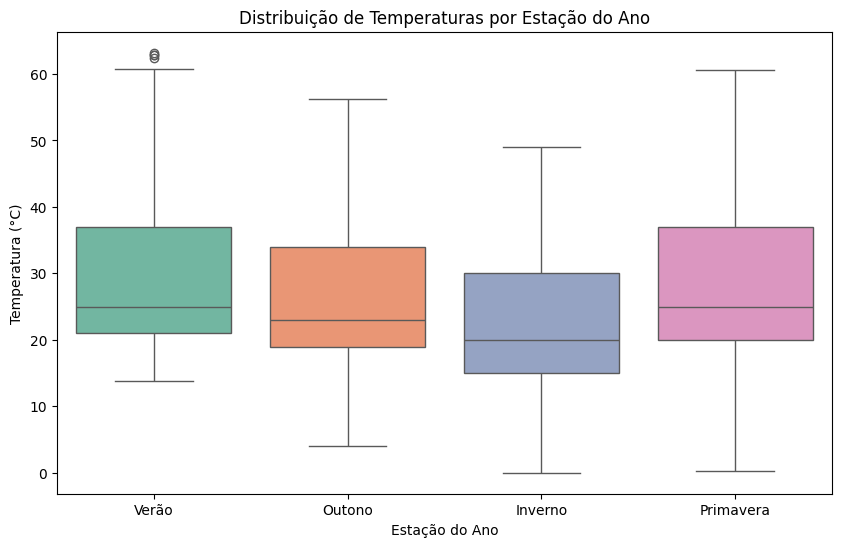

In [20]:
# Boxplot de temperaturas por estação do ano
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='temperaturatermometro', data=clean_data, palette='Set2')
plt.title('Distribuição de Temperaturas por Estação do Ano')
plt.xlabel('Estação do Ano')
plt.ylabel('Temperatura (°C)')
plt.show()

In [21]:
# Resultados das análises
print("\n1a) Status Normal X Erros (Geral):")
print(status_counts)
print(status_percentages)


1a) Status Normal X Erros (Geral):
error_category
Normal               216850
ErroTOCF              14542
ManualEquipamento      3740
ErroTO                 2490
Erro Consistência       205
Name: count, dtype: int64
error_category
Normal               91.18
ErroTOCF              6.11
ManualEquipamento     1.57
ErroTO                1.05
Erro Consistência     0.09
Name: count, dtype: float64


In [22]:
print("\n1a) Status Normal X Erros (Mensal):")
print(monthly_status_counts)
print(monthly_status_percentages)


1a) Status Normal X Erros (Mensal):
error_category  Erro Consistência  ErroTO  ErroTOCF  ManualEquipamento  Normal
year_month                                                                    
2020-02                         0       0        53                  0    3413
2020-03                         0       0      3617                  0    1657
2020-04                         0       0       764                  0    3913
2020-05                         0       0       140                492    4303
2020-06                         0       0         3                  0    3718
2020-07                         0       0         2                  0    4462
2020-08                         0       0         2                  0    4155
2020-09                         0       0         0                  0    4307
2020-10                         0       0         0                  0    4380
2020-11                         0       0        52                  7    4282
2020-12        

In [23]:
print("\n1b) Tipos de Erro (Geral):")
print(error_counts)
print(error_percentages)


1b) Tipos de Erro (Geral):
error_category
ErroTOCF             14542
ManualEquipamento     3740
ErroTO                2490
Erro Consistência      205
Name: count, dtype: int64
error_category
ErroTOCF             69.32
ManualEquipamento    17.83
ErroTO               11.87
Erro Consistência     0.98
Name: count, dtype: float64


In [24]:
print("\n1b) Tipos de Erro (Mensal):")
print(total_monthly_errors)
print(monthly_error_percentages)


1b) Tipos de Erro (Mensal):
error_category  Erro Consistência  ErroTO  ErroTOCF  ManualEquipamento
year_month                                                            
2020-02                         0       0        53                  0
2020-03                         0       0      3617                  0
2020-04                         0       0       764                  0
2020-05                         0       0       140                492
2020-06                         0       0         3                  0
2020-07                         0       0         2                  0
2020-08                         0       0         2                  0
2020-11                         0       0        52                  7
2021-01                         0       0         1                 74
2021-03                         0       0         3                753
2021-05                         0       0        60                  0
2021-08                         0       0       

In [25]:
print("\n2) Máximas e Mínimas Absolutas por Ano:")
print(yearly_stats)


2) Máximas e Mínimas Absolutas por Ano:
      min   max
year           
2020  4.0  54.0
2021  0.0  55.0
2022  4.0  54.0
2023  0.0  58.8
2024  0.3  63.2


In [26]:
print("\n2) Máximas e Mínimas Absolutas por Mês e Ano:")
print(monthly_stats)


2) Máximas e Mínimas Absolutas por Mês e Ano:
    year  month   min   max
0   2020      2  15.0  52.0
1   2020      3  14.0  52.0
2   2020      4  11.0  48.0
3   2020      5   4.0  41.0
4   2020      6   8.0  44.0
5   2020      7   4.0  42.0
6   2020      8   7.0  47.0
7   2020      9  13.0  52.0
8   2020     10  14.0  53.0
9   2020     11  10.0  54.0
10  2020     12  17.0  54.0
11  2021      1  16.0  55.0
12  2021      2  15.0  52.0
13  2021      3  15.0  51.0
14  2021      4  11.0  47.0
15  2021      5   7.0  44.0
16  2021      6   2.0  42.0
17  2021      7   0.0  45.0
18  2021      8   7.0  49.0
19  2021      9  12.0  50.0
20  2021     10  12.0  49.0
21  2021     11  12.0  55.0
22  2021     12  14.0  52.0
23  2022      1  17.0  53.0
24  2022      2  16.0  49.0
25  2022      3  17.0  50.0
26  2022      4   9.0  50.0
27  2022      5   4.0  47.0
28  2022      6   5.0  43.0
29  2022      7   8.0  45.0
30  2022      8   6.0  48.0
31  2022      9   8.0  49.0
32  2022     10  14.0  54.0
3

## Gráfico de máximas e mínimas de erros em percentual

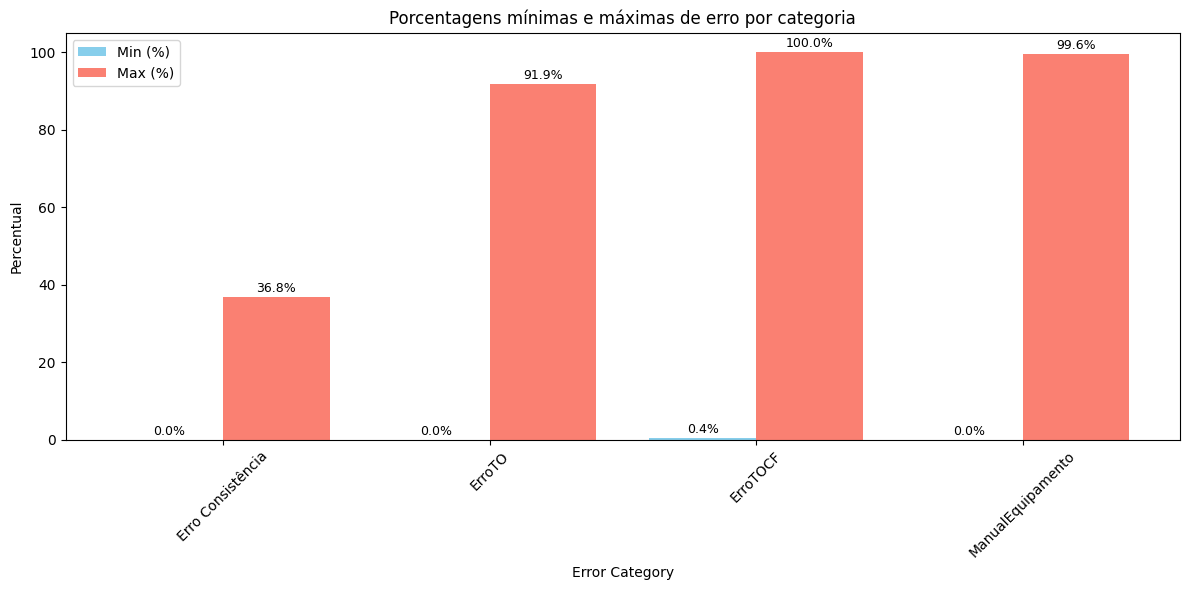

In [33]:
# Gráfico de máximas e mínimas de erros em percentual
graph_data = monthly_error_percentages.agg(['min', 'max']).T.reset_index()
graph_data.columns = ['Error Category', 'Min (%)', 'Max (%)']

plt.figure(figsize=(12, 6))
bar_width = 0.4
index = np.arange(len(graph_data))

bars_min = plt.bar(index, graph_data['Min (%)'], bar_width, label='Min (%)', color='skyblue')
bars_max = plt.bar(index + bar_width, graph_data['Max (%)'], bar_width, label='Max (%)', color='salmon')

for bar in bars_min:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars_max:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

plt.xlabel('Error Category')
plt.ylabel('Percentual')
plt.title('Porcentagens mínimas e máximas de erro por categoria')
plt.xticks(index + bar_width / 2, graph_data['Error Category'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Gráfico de máximas e mínimas por ano

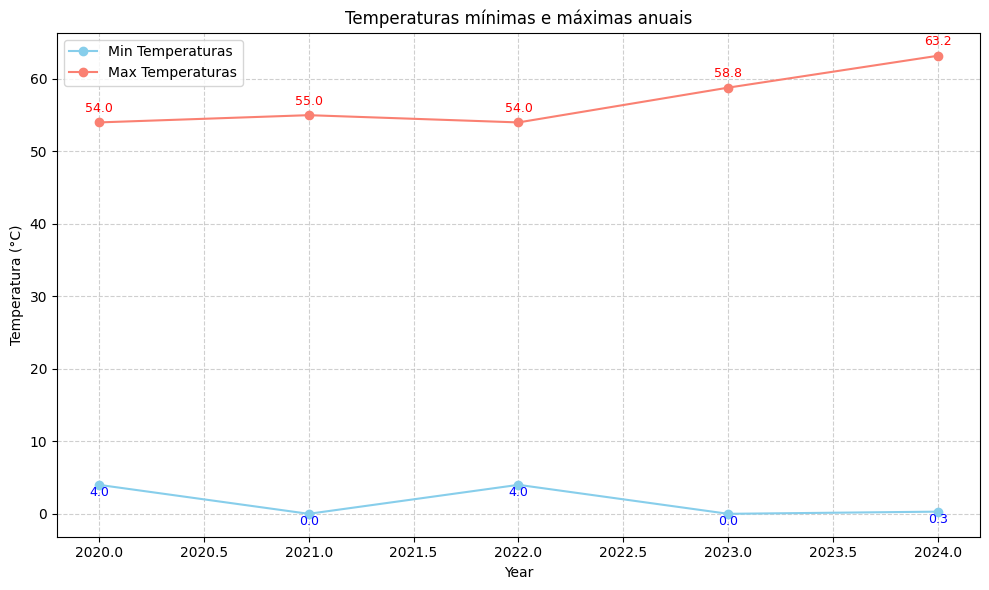

In [31]:
yearly_stats = {
    'year': [2020, 2021, 2022, 2023, 2024],
    'min': [4.0, 0.0, 4.0, 0.0, 0.3],
    'max': [54.0, 55.0, 54.0, 58.8, 63.2]
}

years = yearly_stats['year']
mins = yearly_stats['min']
maxs = yearly_stats['max']

plt.figure(figsize=(10, 6))

plt.plot(years, mins, marker='o', label='Min Temperaturas', color='skyblue')
plt.plot(years, maxs, marker='o', label='Max Temperaturas', color='salmon')

for i, (year, min_temp, max_temp) in enumerate(zip(years, mins, maxs)):
    plt.text(year, min_temp - 2, f'{min_temp:.1f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(year, max_temp + 1, f'{max_temp:.1f}', ha='center', va='bottom', fontsize=9, color='red')

plt.xlabel('Year')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas mínimas e máximas anuais')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


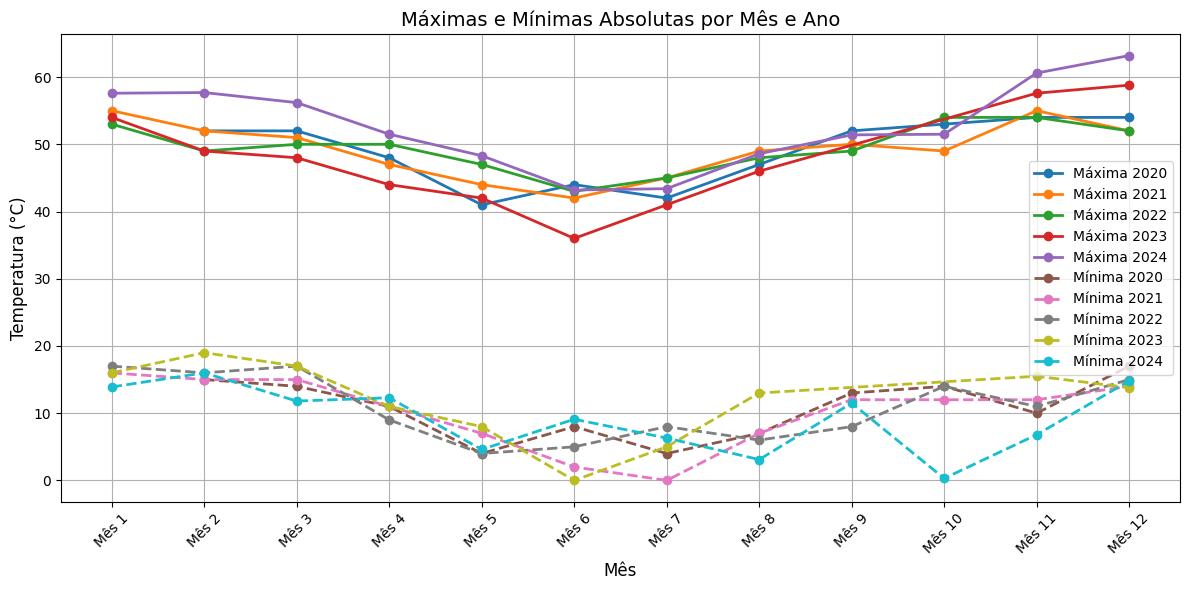

In [32]:
monthly_stats = pd.DataFrame(monthly_stats)

plt.figure(figsize=(12, 6))

for year in monthly_stats['year'].unique():
    subset = monthly_stats[monthly_stats['year'] == year]
    plt.plot(subset['month'], subset['max'], label=f'Máxima {year}', marker='o', linestyle='-', linewidth=2)

for year in monthly_stats['year'].unique():
    subset = monthly_stats[monthly_stats['year'] == year]
    plt.plot(subset['month'], subset['min'], label=f'Mínima {year}', marker='o', linestyle='--', linewidth=2)

plt.title('Máximas e Mínimas Absolutas por Mês e Ano', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.xticks(monthly_stats['month'].unique(), labels=[f'Mês {i}' for i in monthly_stats['month'].unique()], rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
df_normal.to_csv("C:/Users/Cristiano/OneDrive - Belago Technologies/Documentos/projeto_fnt/data/dataframe_concat.csv", index=False)